# ISLP Ch. 6 Code-along

#### Imports

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (
    Stepwise,
    sklearn_selected,
    sklearn_selection_path
)
from l0bnb import fit_path

## Forward Selection

In [43]:
# load the dataset
Hitters = load_data('hitters')
# how many missing values do we have?
np.isnan(Hitters['Salary']).sum()

59

In [44]:
Hitters = pd.get_dummies(Hitters,drop_first = True)

In [45]:
# drop those missing vals
Hitters = Hitters.dropna()
# check shape
Hitters.shape

(263, 20)

### Cp

In [46]:
# Function to calculate Cp
# sigma2 = 
def nCp (sigma2, estimator, X, Y):
     
    n, p = X.shape # n = num obs, p = num vars,
    
    # Yhat is the estimated  y given x?
    Yhat = estimator.predict(X)
    
    # residual sum squares. Distance pred to actual squared
    RSS = np.sum((Y - Yhat) **2 )
    
    # Cp formula
    return -(RSS + 2 * p * sigma2) / 2

In [47]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [49]:
neg_cp = partial(nCp, sigma2)

In [51]:
strategy = Stepwise.first_peak(
    design,
    direction = 'forward',
    max_terms = len(design.terms)
)

In [52]:
hitters_MSE = sklearn_selected(
    OLS,
    strategy
)

hitters_MSE.fit(
    Hitters, 
    Y
)

hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division_W',
 'Errors',
 'Hits',
 'HmRun',
 'League_N',
 'NewLeague_N',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

## Validation Set and Cross-Validation Approach

### Cross Val

In [53]:
stradegy = Stepwise.fixed_steps(
    design,
    len(design.terms),
    direction='forward'
)

full_path = sklearn_selection_path(OLS,strategy)

full_path.fit(Hitters, Y)

Yhat_in = full_path.predict(Hitters)

Yhat_in.shape

(263, 20)

(50000.0, 250000.0)

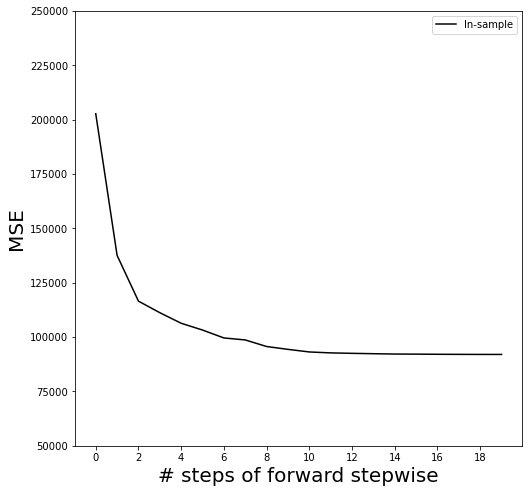

In [54]:
mse_fig , ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
insample_mse ,
'k', # color black
label='In-sample')
ax.set_ylabel('MSE',
fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000])

In [56]:
K = 5
kfold = skm.KFold(
    K,
    random_state=0,
    shuffle = True
)

Yhat_cv = skm.cross_val_predict(
    full_path,
    Hitters,
    Y,
    cv = kfold
)

Yhat_cv.shape

(263, 20)

In [58]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx, None]) ** 2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

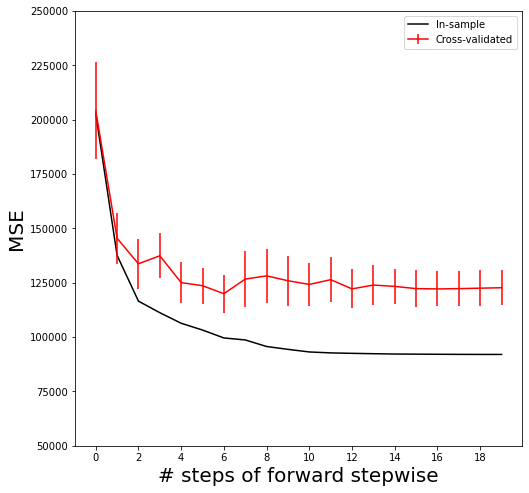

In [60]:
ax.errorbar(
    np.arange(n_steps),
    cv_mse.mean(1),
    cv_mse.std(1) / np.sqrt(K),
    label = 'Cross-validated',
    c= 'r'
)

ax.set_ylim([50000,250000])
ax.legend()
mse_fig

### Validation Set Approach

In [62]:
validation = skm.ShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=0
)

for train_idx, test_idx in validation.split(Y):
    full_path.fit(
        Hitters.iloc[train_idx],
        Y[train_idx]
    )
    
    Yhat_val = full_path.predict(Hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx ,None])**2
    validation_mse = errors.mean(0)

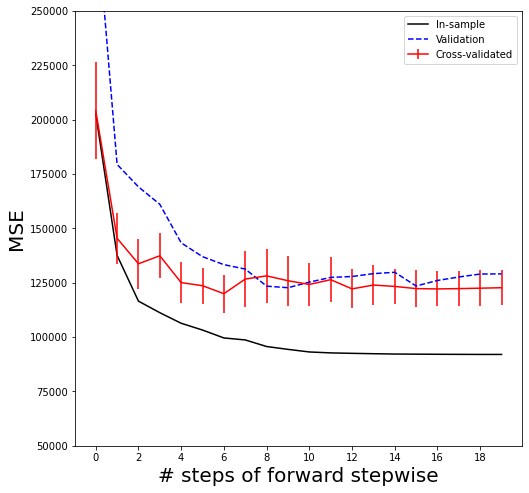

In [63]:
ax.plot(
    np.arange(n_steps),
    validation_mse ,
    'b--', # color blue, broken line
    label='Validation'
)

ax.set_xticks(np.arange(n_steps)[::2])

ax.set_ylim([50000,250000])

ax.legend()

mse_fig

## Best Subset Selection

In [65]:
D = design.fit_transform(Hitters)

D = D.drop('intercept', axis = 1)

X = np.asarray(D)

In [66]:
path = fit_path(
    X,
    Y,
    max_nonzeros=X.shape[1]
)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [67]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.01141624802745019,
 'M': 0.5829861733382015,
 'Time_exceeded': False}

## Ridge Regression

Why error? 
- C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
- C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49896456.01860938, tolerance: 12885.7065737425

In [77]:
import warnings

# Suppress specific UserWarnings from sklearn's coordinate descent module
warnings.filterwarnings("ignore", message="Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.", category=UserWarning, module="sklearn.linear_model._coordinate_descent")


Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(
    Xs, 
    Y,
    l1_ratio=0,
    alphas=lambdas
)[1]

soln_array.shape



C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428069.135193564, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64427947.709570706, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: Con

(19, 100)

In [78]:
soln_path = pd.DataFrame(
    soln_array.T,
    columns=D.columns ,
    index=-np.log(lambdas)
)

soln_path.index.name = 'negative log(lambda)'

soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,0.000609,0.000052,-0.000011,-0.000029,-0.000390,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,0.000769,0.000065,-0.000014,-0.000037,-0.000492,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,0.000970,0.000082,-0.000017,-0.000046,-0.000621,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,0.001224,0.000104,-0.000022,-0.000058,-0.000784,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,0.001544,0.000131,-0.000028,-0.000073,-0.000990,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216196,-387.775825,89.573600,-12.273926,476.079272,257.271255,-213.124780,78.761266,53.622112,-22.208457,31.258216,-58.457857,-12.402891
10.017243,-290.879272,337.113712,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458403,89.000706,-12.661460,477.031348,257.966790,-213.280891,78.761240,53.645147,-22.198802,31.256435,-58.448850,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997469,88.537379,-12.971603,477.791860,258.523025,-213.405740,78.761230,53.663357,-22.191071,31.254959,-58.441682,-12.383205


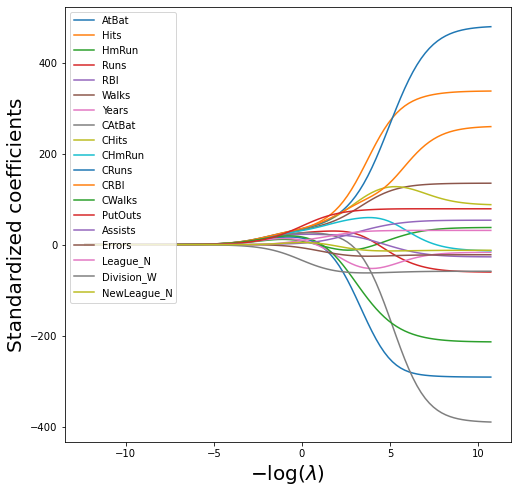

In [79]:
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [80]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat          5.433750
 Hits           6.223582
 HmRun          4.585498
 Runs           5.880855
 RBI            6.195921
 Walks          6.277975
 Years          5.299767
 CAtBat         7.147501
 CHits          7.539495
 CHmRun         7.182344
 CRuns          7.728649
 CRBI           7.790702
 CWalks         6.592901
 PutOuts        4.605263
 Assists        0.378371
 Errors        -0.135196
 League_N       0.042445
 Division_W    -3.107159
 NewLeague_N    0.150323
 Name: -3.240065292879872, dtype: float64)

In [81]:
 np.linalg.norm(beta_hat)

24.170617201443783

In [82]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017726057)

In [84]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

In [85]:
np.linalg.norm(ridge.coef_)

160.4237101772592

#### Estimating error 

In [88]:
validation = skm.ShuffleSplit(
    n_splits=1,
    test_size=0.5,
    random_state=0
)

ridge.alpha = 0.01

results = skm.cross_validate(
    ridge ,
    X,
    Y,
    scoring='neg_mean_squared_error',
    cv=validation
)
-results['test_score']

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134213.99538908])

In [89]:
ridge.alpha = 1e10

results = skm.cross_validate(
    ridge ,
    X,
    Y,
    scoring='neg_mean_squared_error',
    cv=validation
)

-results['test_score']

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([231788.32155285])

In [92]:
param_grid = {'ridge__alpha': lambdas}

grid = skm.GridSearchCV(
    pipe,
    param_grid ,
    cv=validation ,
    scoring='neg_mean_squared_error'
)

grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.055e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.038e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.746e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.715e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [93]:
grid = skm.GridSearchCV(
    pipe,
    param_grid ,
    cv=kfold ,
    scoring='neg_mean_squared_error'
)

grid.fit(X, Y)

grid.best_params_['ridge__alpha']

grid.best_estimator_

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e+07, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+07, tolerance: 4.466e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.220e+07, tolerance: 4.445e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.215e+07, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+07, tolerance: 4.466e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e+07, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e+07, tolerance: 4.466e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e+07, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.135e+07, tolerance: 4.466e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.548e+06, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.650e+06, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.914e+06, tolerance: 4.445e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.145e+06, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.966e+06, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.146e+06, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.114e+06, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.487e+06, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.636e+06, tolerance: 4.445e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.897e+06, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

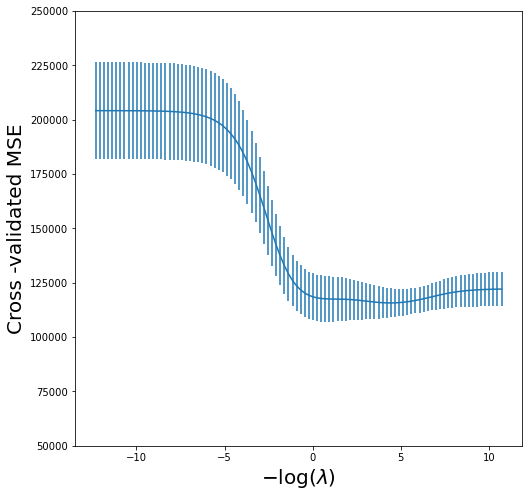

In [94]:
ridge_fig , ax = subplots(figsize=(8,8))

ax.errorbar(
    -np.log(lambdas),            
    -grid.cv_results_['mean_test_score'],
    yerr=grid.cv_results_['std_test_score'] / np.sqrt(K)
)

ax.set_ylim([50000,250000])

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)

ax.set_ylabel('Cross -validated MSE', fontsize=20);

In [95]:
grid_r2 = skm.GridSearchCV(
    pipe,
    param_grid ,
    cv=kfold
)

grid_r2.fit(X, Y)

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e+07, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e+07, tolerance: 4.466e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.215e+07, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+07, tolerance: 4.466e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e+07, tolerance: 4.445e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e+07, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.404e+07, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.114e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.149e+07, tolerance: 4.466e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e+07, tolerance: 4.445e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.727e+06, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.057e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.187e+06, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.314e+06, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.971e+06, tolerance: 4.466e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.717e+06, tolerance: 4.445e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.651e+06, tolerance: 4.445e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.915e+06, tolerance: 4.437e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.108e+06, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.460e+06, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

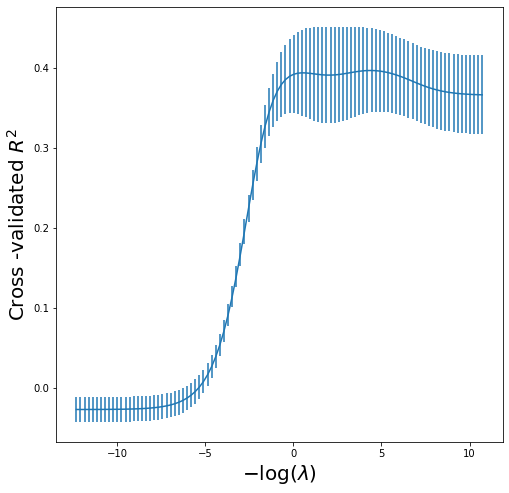

In [97]:
r2_fig , ax = subplots(figsize=(8,8))

ax.errorbar(
    -np.log(lambdas),
    grid_r2.cv_results_['mean_test_score'],
    yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)
)

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)

ax.set_ylabel('Cross -validated $R^2$', fontsize=20);

In [98]:
ridgeCV = skl.ElasticNetCV(
    alphas=lambdas ,
    l1_ratio=0,
    cv=kfold
)

pipeCV = Pipeline(
    steps=[
        ('scaler', scaler),
           ('ridge', ridgeCV)
    ]
)

pipeCV.fit(X, Y)

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18795326.35550233, tolerance: 3759.109166869192
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18795268.885511454, tolerance: 3759.109166869192
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18795196.367825, tolerance: 3759.109166869192
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: Con

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12366168.387483235, tolerance: 4201.186103419478
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12175587.278453032, tolerance: 4201.186103419478
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12002182.95826825, tolerance: 4201.186103419478
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: 

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9890425.865192188, tolerance: 4466.452064951529
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9889395.604661671, tolerance: 4466.452064951529
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9888574.440116936, tolerance: 4466.452064951529
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: Co

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21612729.922244653, tolerance: 4436.577708196867
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21473368.08108257, tolerance: 4436.577708196867
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21302902.694377463, tolerance: 4436.577708196867
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: 

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606e+04, 2.16987845e+04, 1.71959156e+04,
       1.36274691e+04, 1.07995362e+04, 8.55844774e+03, 6.78242347e+03,
       5.37495461e+03, 4.25955961e+03,...
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

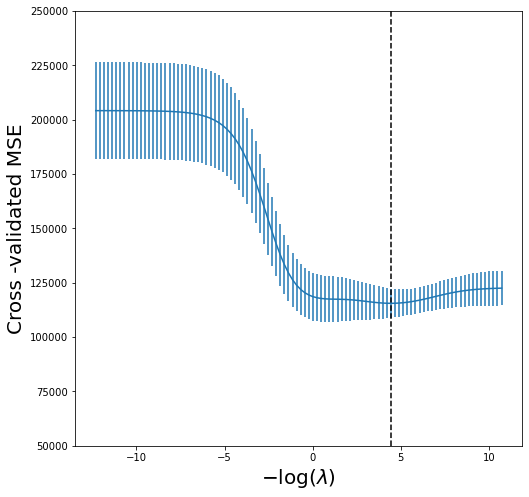

In [100]:
tuned_ridge = pipeCV.named_steps['ridge']

ridgeCV_fig , ax = subplots(figsize=(8,8))

ax.errorbar(
    -np.log(lambdas),
    tuned_ridge.mse_path_.mean(1),
    yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K)
)

ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')

ax.set_ylim([50000,250000])

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)

ax.set_ylabel('Cross -validated MSE', fontsize=20);

In [101]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630988914

In [102]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731986,
        122.00714802,   57.18595091,  210.35170349,  118.05683746,
       -150.21959435,   77.73832472,   40.07350744,  -25.02151514,
         30.36634231,  -61.62459095,  -13.68429544])

## Evaluating Test Error of Cross-Validated Ridge

In [104]:
outer_valid = skm.ShuffleSplit(
    n_splits=1,                      
    test_size=0.25,                    
    random_state=1
)

inner_cv = skm.KFold(
    n_splits=5,
    shuffle=True,
    random_state=2
)

ridgeCV = skl.ElasticNetCV(
    alphas=lambdas ,
    l1_ratio=0,
    cv=inner_cv
)

pipeCV = Pipeline(
    steps=[('scaler', scaler),
           ('ridge', ridgeCV)]
)

In [105]:
results = skm.cross_validate(
    pipeCV ,                     
    X,                  
    Y,                    
    cv=outer_valid,
    scoring='neg_mean_squared_error'
)
-results['test_score']

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002961.89304734, tolerance: 3200.6325551004934
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002909.292721536, tolerance: 3200.6325551004934
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002842.919898542, tolerance: 3200.6325551004934
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:66

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14914100.653844738, tolerance: 3034.76265980692
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14849699.805850955, tolerance: 3034.76265980692
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14770425.961151278, tolerance: 3034.76265980692
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: Co

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7597526.506006155, tolerance: 3200.070250165818
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7542012.431575993, tolerance: 3200.070250165818
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7491270.131106973, tolerance: 3200.070250165818
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: Co

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16109432.474341484, tolerance: 3224.8236814135257
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16105594.879294185, tolerance: 3224.8236814135257
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16100757.119470125, tolerance: 3224.8236814135257
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:6

array([132393.84003227])

## The Lasso

In [106]:
lassoCV = skl.ElasticNetCV(
    n_alphas=100,
    l1_ratio=1,
    cv=kfold
)

pipeCV = Pipeline(
    steps=[
        ('scaler', scaler),
        ('lasso', lassoCV)
    ]
)

pipeCV.fit(X, Y)

tuned_lasso = pipeCV.named_steps['lasso']

tuned_lasso.alpha_

3.1472370031649866

In [107]:
lambdas , soln_array = skl.Lasso.path(
    Xs,
    Y,
    l1_ratio=1,
    n_alphas=100
)[:2]

soln_path = pd.DataFrame(
    soln_array.T,
    columns=D.columns ,
    index=-np.log(lambdas)
)

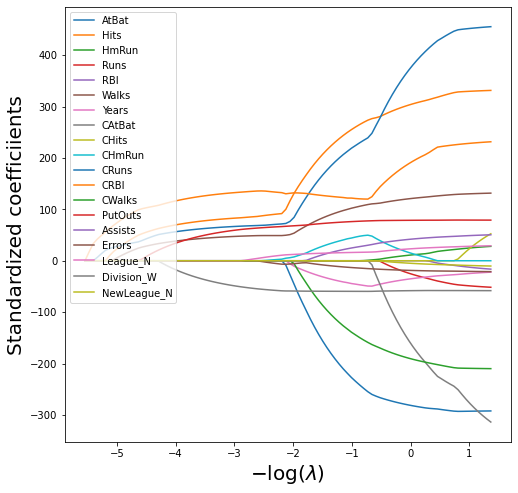

In [108]:
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [109]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.72511801412

Text(0, 0.5, 'Cross -validated MSE')

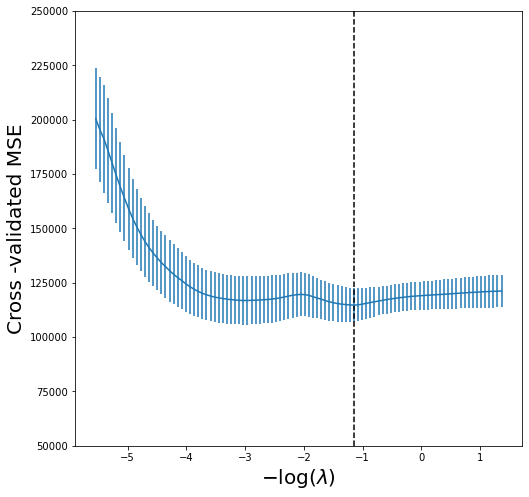

In [111]:
lassoCV_fig , ax = subplots(figsize=(8,8))

ax.errorbar(
    -np.log(tuned_lasso.alphas_),
    tuned_lasso.mse_path_.mean(1),
    yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K)
)

ax.axvline(
    -np.log(tuned_lasso.alpha_),
    c='k', ls='--'
)

ax.set_ylim([50000,250000])

ax.set_xlabel('$-\log(\lambda)$', fontsize=20)

ax.set_ylabel('Cross -validated MSE', fontsize=20)

In [112]:
tuned_lasso.coef_

array([-210.01024284,  243.45499529,    0.        ,    0.        ,
          0.        ,   97.69407763,  -41.52295051,   -0.        ,
          0.        ,   39.62307229,  205.75339911,  124.55436745,
       -126.30028802,   75.2459413 ,   21.62699585,  -12.0441519 ,
         15.70262131,  -59.50158636,   -0.        ])

## PCR and PLS Regression

In [113]:
pca = PCA(n_components=2)

linreg = skl.LinearRegression()

pipe = Pipeline(
    [
        ('pca', pca),
        ('linreg', linreg)
    ]
)

pipe.fit(X, Y)

pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [114]:
pipe = Pipeline(
    [
        ('scaler', scaler),
        ('pca', pca),
        ('linreg', linreg)
    ]
)

pipe.fit(X, Y)

pipe.named_steps['linreg'].coef_

array([106.36859204, -21.60350456])

In [115]:
param_grid = {'pca__n_components': range(1, 20)}

grid = skm.GridSearchCV(
    pipe,
    param_grid ,
    cv=kfold ,
    scoring='neg_mean_squared_error'
)

grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

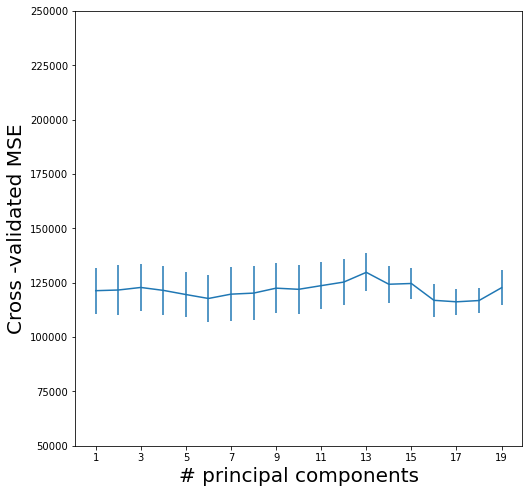

In [116]:
pcr_fig , ax = subplots(figsize=(8,8))

n_comp = param_grid['pca__n_components']

ax.errorbar(
    n_comp ,
    -grid.cv_results_['mean_test_score'],
    grid.cv_results_['std_test_score'] / np.sqrt(K)
)

ax.set_ylabel('Cross -validated MSE', fontsize=20)

ax.set_xlabel('# principal components', fontsize=20)

ax.set_xticks(n_comp[::2])

ax.set_ylim([50000,250000])

In [117]:
Xn = np.zeros((X.shape[0], 1))

cv_null = skm.cross_validate(
    linreg ,
    Xn,
    Y,
    cv=kfold ,
    scoring='neg_mean_squared_error'
)

-cv_null['test_score'].mean()

204139.30692994667

In [118]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

### PLS

In [119]:
pls = PLSRegression(
    n_components=2,    
    scale=True
)

pls.fit(X, Y)

PLSRegression()

In [120]:
param_grid = {'n_components':range(1, 20)}

grid = skm.GridSearchCV(
    pls,
    param_grid ,
    cv=kfold ,
    scoring='neg_mean_squared_error'
)

grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

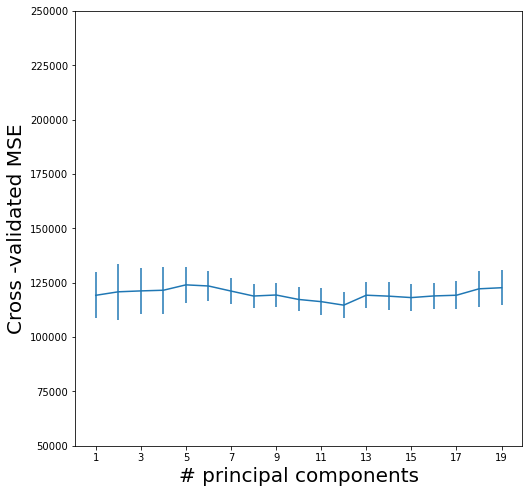

In [121]:
pls_fig , ax = subplots(figsize=(8,8))

n_comp = param_grid['n_components']

ax.errorbar(
    n_comp ,
    -grid.cv_results_['mean_test_score'],
    grid.cv_results_['std_test_score'] / np.sqrt(K)
)

ax.set_ylabel('Cross -validated MSE', fontsize=20)

ax.set_xlabel('# principal components', fontsize=20)

ax.set_xticks(n_comp[::2])

ax.set_ylim([50000,250000]);